In [1]:
import numpy as np
import os
import time
import pygrib
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

## load a random grib file

In [2]:
file_list = os.listdir('/media/storage/DATA/filtered_weather_data/namanl/')
file_list.sort()
st = time.time()
grbs = pygrib.open('/media/storage/DATA/filtered_weather_data/namanl/%s'%file_list[np.random.randint(0, len(file_list))])
uwind = grbs.select(shortName = 'u', typeOfLevel='isobaricInhPa')
vwind = grbs.select(shortName = 'v', typeOfLevel='isobaricInhPa')
tempr = grbs.select(shortName = 't', typeOfLevel='isobaricInhPa')
grbs.close()
print(time.time() - st)
basegrid_lat = uwind[0].latlons()[0]
basegrid_lon = uwind[0].latlons()[1]
basegrid = np.vstack((basegrid_lon.flatten(), basegrid_lat.flatten())).T

llon = -130
rlon = -64
tlat = 52
blat = 22

idx_lon = (basegrid_lat >= blat) & (basegrid_lat <= tlat)
idx_lat = (basegrid_lon >= llon) & (basegrid_lon <= rlon)
small_idx = idx_lat * idx_lon

basegrid_small = np.vstack((basegrid_lon[small_idx], basegrid_lat[small_idx])).T

lvls = []
for i in uwind:
    lvls.append(i.level)
lvls.sort(
lvls = np.array(lvls)

0.9400367736816406


In [3]:
basegrid_small.shape

(138934, 2)

In [3]:
np.savez('/media/storage/DATA/filtered_weather_data/grbs_common_info.npz', 
         basegrid_lat = basegrid_lat, 
         basegrid_lon = basegrid_lon, 
         basegrid = basegrid,
         smallgrid = basegrid_small,
         small_idx = small_idx,
         levels = lvls)

In [ ]:
import pickle
from scipy.spatial import cKDTree

In [ ]:
smallgrid_tree = cKDTree(smallgrid)
with open('/media/storage/DATA/filtered_weather_data/grbs_level_common_info.pkl', 'wb') as pfile:
    pickle.dump(lvls_dict, pfile)
with open('/media/storage/DATA/filtered_weather_data/grbs_smallgrid_kdtree.pkl', 'wb') as pfile:
    pickle.dump(smallgrid_tree, pfile)

## Visualize georeference grid

/home/liuyulin/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/liuyulin/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


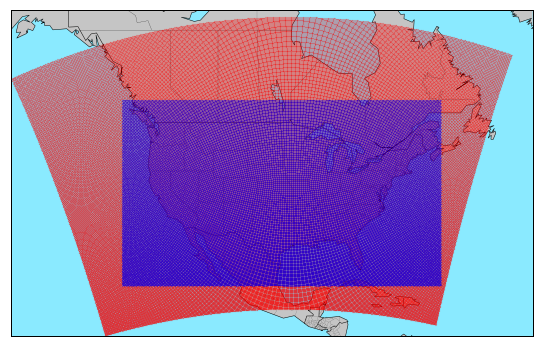

In [4]:
plt.figure(figsize=(10,6))
m = Basemap(llcrnrlon = -153,llcrnrlat = 12.,urcrnrlon = -45,urcrnrlat = 62,projection='merc')
m.drawmapboundary(fill_color='#8aeaff')
m.fillcontinents(color='#c5c5c5', lake_color='#8aeaff')
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.1)

x, y = m(basegrid_lon.flatten(), basegrid_lat.flatten())
xsmall, ysmall = m(basegrid_small[:, 0], basegrid_small[:, 1])

plt.plot(x, y, 'ro',ms = 0.1)
plt.plot(xsmall, ysmall, 'bo',ms = 0.1)

## smaller grb to npz

In [6]:
grbs_common_info = np.load('/media/storage/DATA/filtered_weather_data/grbs_common_info.npz')
basegrid_lat = grbs_common_info['basegrid_lat']
basegrid_lon = grbs_common_info['basegrid_lon']
basegrid = grbs_common_info['basegrid']
smallgrid = grbs_common_info['smallgrid']
small_idx = grbs_common_info['small_idx']
lvls = grbs_common_info['levels']
lvls_dict = {}
i = 0
for lvl in lvls:
    lvls_dict[lvl] = i
    i += 1

In [9]:
file_list = os.listdir('/media/storage/DATA/filtered_weather_data/namanl/')
file_list.sort()
st = time.time()

try:
    os.makedirs('/home/liuyulin/Desktop/DATA/filtered_weather_data/namanl_small_npz/')
except:
    pass
kfile = 0
for fname in file_list:
    if fname.endswith('.grb'):
        grbs = pygrib.open('/media/storage/DATA/filtered_weather_data/namanl/%s'%fname)
        uwind = grbs.select(shortName = 'u', typeOfLevel='isobaricInhPa')
        vwind = grbs.select(shortName = 'v', typeOfLevel='isobaricInhPa')
        tempr = grbs.select(shortName = 't', typeOfLevel='isobaricInhPa')


        tmp_uwind = np.zeros((lvls.shape[0], smallgrid.shape[0]), dtype = np.float32)
        tmp_vwind = np.zeros((lvls.shape[0], smallgrid.shape[0]), dtype = np.float32)
        tmp_tempr = np.zeros((lvls.shape[0], smallgrid.shape[0]), dtype = np.float32)
        for i in range(len(uwind)):
            try:
                tmp_uwind[lvls_dict[uwind[i].level]] = uwind[i].data()[0][small_idx].astype(np.float32)
            except Exception as err:
                print(fname, err)
                pass

        for i in range(len(vwind)):
            try:
                tmp_vwind[lvls_dict[vwind[i].level]] = vwind[i].data()[0][small_idx].astype(np.float32)
            except Exception as err:
                print(fname, err)
                pass

        for i in range(len(tempr)):
            try:
                tmp_tempr[lvls_dict[tempr[i].level]] = tempr[i].data()[0][small_idx].astype(np.float32)
            except Exception as err:
                print(fname, err)
                pass

        grbs.close()
        np.savez_compressed('/home/liuyulin/Desktop/DATA/filtered_weather_data/namanl_small_npz/%s.npz'%fname[:-4], 
                            uwind = tmp_uwind, 
                            vwind = tmp_vwind, 
                            tempr = tmp_tempr)
        if kfile % 100 == 0:
            print('%d files processed, elapsed time: %.2f seconds'%(kfile + 1, time.time() - st))
        kfile += 1
    else:
        pass

1 files processed, elapsed time: 7.70 seconds
101 files processed, elapsed time: 775.38 seconds
201 files processed, elapsed time: 1564.98 seconds
301 files processed, elapsed time: 2341.96 seconds
401 files processed, elapsed time: 3134.83 seconds
501 files processed, elapsed time: 3922.74 seconds
601 files processed, elapsed time: 4708.02 seconds
701 files processed, elapsed time: 5497.29 seconds
801 files processed, elapsed time: 6286.71 seconds
901 files processed, elapsed time: 7083.06 seconds
1001 files processed, elapsed time: 7876.40 seconds
1101 files processed, elapsed time: 8666.97 seconds
1201 files processed, elapsed time: 9462.51 seconds
1301 files processed, elapsed time: 10257.30 seconds
1401 files processed, elapsed time: 11038.18 seconds
1501 files processed, elapsed time: 11834.77 seconds
1601 files processed, elapsed time: 12618.37 seconds
1701 files processed, elapsed time: 13394.45 seconds
1801 files processed, elapsed time: 14186.56 seconds
1901 files processed, 